## Imports

In [2]:
import pandas as pd
import numpy as np 
from math import exp
import seaborn as sns
import matplotlib.pyplot as plt
import json
from scipy.stats import iqr
from random import uniform as u
%matplotlib inline
sns.set()

# Get data

In [3]:
cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recov = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

## Set ```N```,```dt``` ,```alfa``` and ```days_historic``` , and calculate ```s_data``` 

In [4]:
N = 2e8 #Initial population
country = 'Brazil'
i_data = np.array(cases[cases['Country/Region']==country].iloc[0,4:])
outbreak = np.where(i_data>0)[0][0]
i_data = i_data[outbreak:] #infected daily
r_data = np.array(recov[recov['Country/Region']==country].iloc[0,4:])
r_data = r_data[outbreak:] #recovered daily
days_historic = [i for i in range(len(i_data))]

#N = S+I+R
s_data = np.array([N-(i_data[i]+r_data[i]) for i in range(len(i_data))])
alfa = 0.03

## Plot historic data

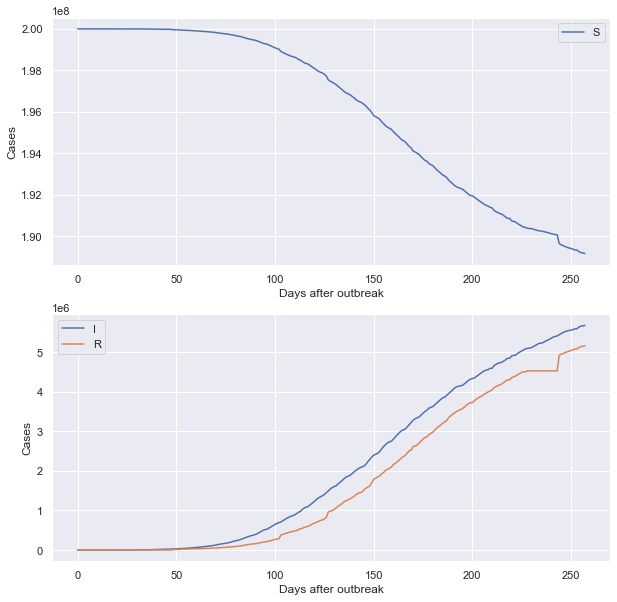

In [5]:
fig,axs = plt.subplots(2)
fig.set_size_inches(10, 10, forward=True)
axs[0].plot(s_data,label='S')
axs[1].plot(i_data,label='I')
axs[1].plot(r_data,label='R')
axs[0].set_xlabel('Days after outbreak')
axs[1].set_xlabel('Days after outbreak')
axs[0].set_ylabel('Cases')
axs[1].set_ylabel('Cases')
axs[0].legend()
axs[1].legend();

## Calculate ```beta_data```, ```ro_data``` and ```R0_data```

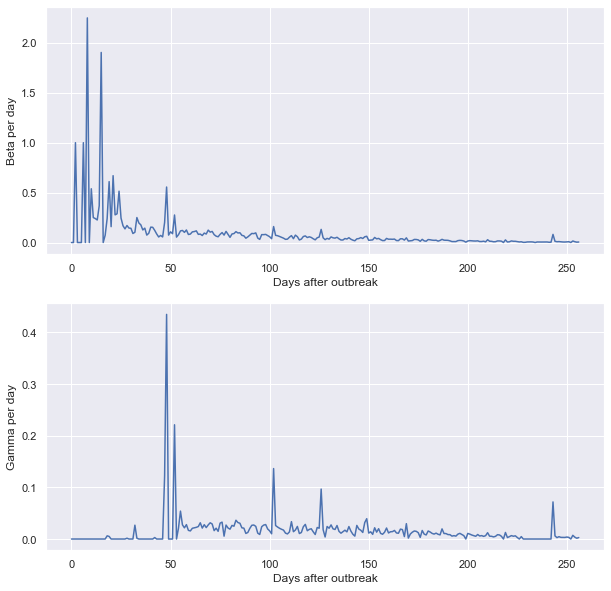

In [6]:
#s'(t) = -beta*s(t)*i(t)*dt/N => beta = -s'(t)*N/(s(t)*i(t)) => beta = N*(s(k)-s(k+1))/(s(k)*i(k))
beta_data = np.array([(s_data[i]-s_data[i+1])*N/(s_data[i]*i_data[i]) for i in range(len(s_data)-1)])
beta_data[np.isnan(beta_data)] = 0.0
beta_data = beta_data.round(4)

#r'(t) = gamma*i(t) => gamma = (r(k+1)-r(k))/i(k)

gamma_data = np.array([(r_data[i+1]-r_data[i])/i_data[i] for i in range(len(r_data)-1)])

fig,axs = plt.subplots(2)
fig.set_size_inches(10,10, forward=True)
axs[0].plot(beta_data)
axs[1].plot(gamma_data)
axs[0].set_xlabel('Days after outbreak')
axs[1].set_xlabel('Days after outbreak')
axs[0].set_ylabel('Beta per day')
axs[1].set_ylabel('Gamma per day');

## Remove outliers

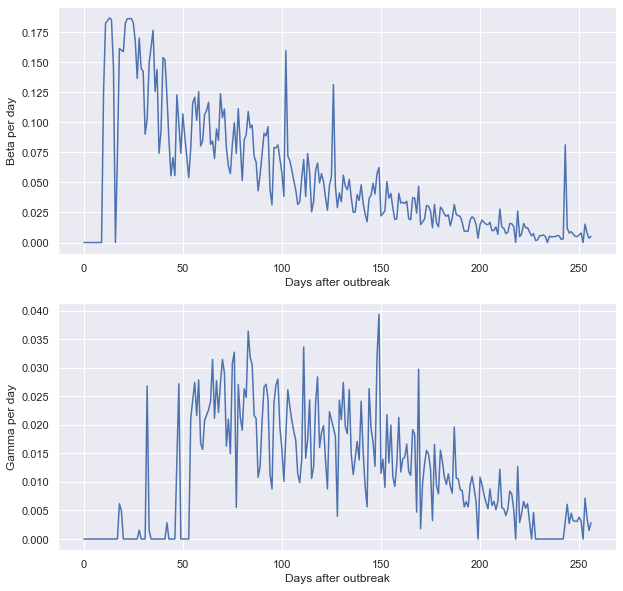

In [7]:
p_25, p_75 = np.percentile(beta_data, [25, 75])
iqr = p_75 - p_25

upper_bound_beta = p_75 + 1.5 * iqr
lower_bound_beta = p_75 + 1.5 * iqr 

p_25, p_75 = np.percentile(gamma_data, [25, 75])
iqr = p_75 - p_25

upper_bound_gamma = p_75 + 1.5 * iqr
lower_bound_gamma = p_25 - 1.5 * iqr

def remove_outliers(lower,upper,data):
    
    def have_outliers(data):
        for x in data:
            if x < lower or x > upper:
                return True
        return False
    while have_outliers(data):
        for i in range(len(data)-1):
            if data[i] < lower or data[i]> upper:
                data[i] = (data[i-1]+data[i+1])/2
            else:
                pass
        

    return data
beta_data = remove_outliers(0.0,upper_bound_beta,beta_data)
gamma_data = remove_outliers(0.0,upper_bound_gamma,gamma_data)
fig,axs = plt.subplots(2)
fig.set_size_inches(10,10, forward=True)
axs[0].plot(beta_data)
axs[1].plot(gamma_data)
axs[0].set_xlabel('Days after outbreak')
axs[1].set_xlabel('Days after outbreak')
axs[0].set_ylabel('Beta per day')
axs[1].set_ylabel('Gamma per day');

# Fitting the curve for ```beta_data``` and ```ro_data```

### Removing initial zeroish elements (this is just for fitting)

In [8]:
for i in range(len(beta_data)):
    if round(beta_data[i],2) != .00:
        fit_beta = i
        break
        
beta_data_fit = beta_data[fit_beta:]
fit_gamma = 80
gamma_data_fit = gamma_data[fit_gamma:]

### Functions used to fit

In [11]:
def fit_fun_beta(data,A,b):
    tol = 1e-9
    p = 0.0001
    N = 50
    def y(A, b, x):
        return A*exp(b*x) 
    def gradiente(A, b, data):
        derA = 0
        derB = 0
        for xi, yi in data:
            derA += 2*(y(A, b, xi)-yi)*exp(b*xi)
            derB += 2*(y(A, b, xi)-yi)*A*(-xi)*exp(b*xi)
        derA/=len(data)
        derB/=len(data)

        return derA, derB

    count = 0
    derA, derB = gradiente(A, b, data)
    while count < N and abs(derA) > tol and abs(derB) > tol:
        A -= derA*p
        b -= derB*p
        derA, derB = gradiente(A, b, data)
        count += 1
    return A,b

def fit_fun_gamma(data,a,b):
    tol = 1e-4
    p = 3e-5
    N = 50
    def y(a,b,x):
        return a*x+b
    def gradiente(a, b, data):
        derA = 0.
        derB = 0.
        for xi, yi in data:
            derA += 2*(y(a, b, xi)-yi)*xi
            derB += 2*(y(a, b, xi)-yi)
            
        derA/=len(data)
        derB/=len(data)
        return derA, derB

    count = 0
    derA, derB = gradiente(a, b, data)
    while count < N and abs(derA) > tol and abs(derB) > tol:
        a -= derA*p
        b -= derB*p
        derA, derB = gradiente(a, b, data)
        count += 1
        
    return a,b

A0_beta= 0.2
b0_beta= -.01
a0_gamma = -0.00002
b0_gamma = .035

#correct the days starting at the first non-zeroish value

days_beta_fit = [i+fit_beta for i in range(len(beta_data_fit))]
days_gamma_fit = [i+fit_gamma for i in range(len(gamma_data_fit))]

A_beta,b_beta = fit_fun_beta(list(zip(days_beta_fit,beta_data_fit)),A0_beta,b0_beta)
a_gamma, b_gamma = fit_fun_gamma(list(zip(days_gamma_fit,gamma_data_fit)),a0_gamma,b0_gamma)

print(A_beta,b_beta)
print(a_gamma,b_gamma)

0.1999500877315587 -0.009197024743569874
-0.0001351927964033701 0.034999336926615124


## Comparing data and fitted curve

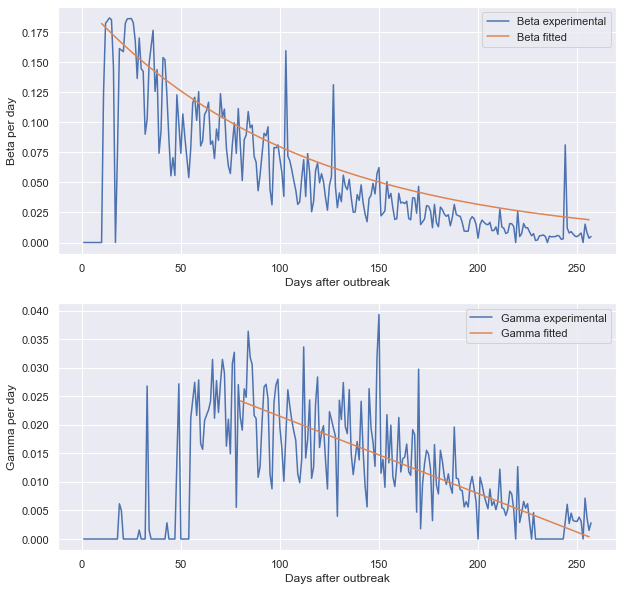

In [12]:
def y_exp(A, b, x):
    return A*exp(b*x) 
def y_linear(a,b,x):
    return a*x+b

beta_curve = [y_exp(A_beta,b_beta,day) for day in days_beta_fit]
gamma_curve = [y_linear(a_gamma,b_gamma,day) for day in days_gamma_fit]
days_gamma_beta = [i for i in range(1,len(days_historic))] #as beta and gamma are calculated by getting previous and current values of s,i,r,d, they have 1 value less than these 4 parameters
fig,axs = plt.subplots(2)
fig.set_size_inches(10,10, forward=True)
axs[0].plot(days_gamma_beta,beta_data,label="Beta experimental")
axs[0].plot(days_beta_fit,beta_curve,label="Beta fitted")
axs[1].plot(days_gamma_beta,gamma_data,label="Gamma experimental")
axs[1].plot(days_gamma_fit,gamma_curve,label="Gamma fitted")
axs[0].set_xlabel('Days after outbreak')
axs[1].set_xlabel('Days after outbreak')
axs[0].set_ylabel('Beta per day')
axs[1].set_ylabel('Gamma per day')
axs[0].legend();
axs[1].legend();

# Simulate future

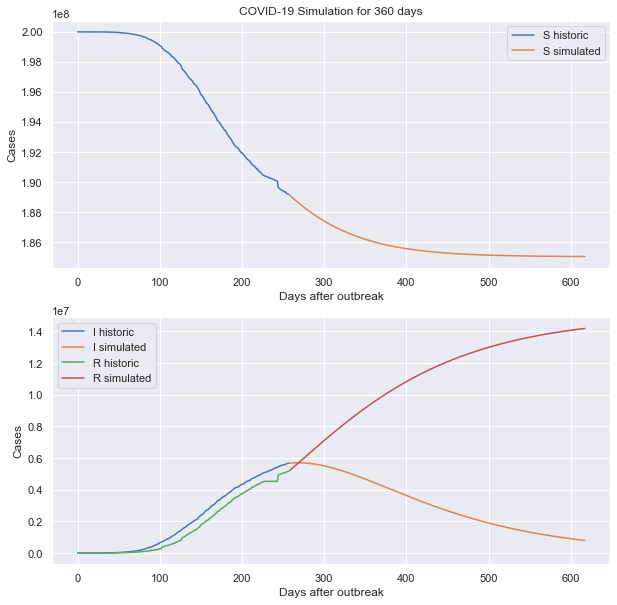

In [17]:
T = 360   #number of sim (dt days)
t0 = len(s_data) #the first day of simulation is the next day from last historic data

def y_exp_sim(day,A,b,tol):
    if round(A*exp(b*day),tol) == round(0.0,tol):
        return 10**(-tol)
    else:
         return round(A*exp(b*day),tol)
def y_linear_sim(day,a,b,tol):
    if round(a*day+b,tol) == round(0.0,tol):
        return 10**(-tol)
    else:
         return round(a*day+tol,tol)
        
data=[]

#Initial conditions

S=s_data[-1]
I=i_data[-1]
R=r_data[-1]
t = 0.0
h = 1.0
tol = 4

while t < T:

    if I==0 or R == 0:
        break
        
    b = y_exp(A_beta,b_beta,t+t0)/2.0
    g = 8e-3

    
    dS= -int(b*S*I/N)
    #print(b,S,I)
    #print(t+t0,g)
    dR= int(g*I)
    dI = -(dS+dR)

    S+=int(dS*h)
    R+=int(dR*h)
    I+=int(dI*h)
    
    #print(S,I,R)
    
    data.append([S,I,R])
    t+=h

data = np.array(data)

days = [i for i in range(T+t0)]

fig,axs=plt.subplots(2)
fig.set_size_inches(10,10, forward=True)

axs[0].plot(days[:t0],s_data,label='S historic')
axs[0].plot(days[t0:],data[:,0],label='S simulated')

axs[1].plot(days[:t0],i_data,label='I historic')
axs[1].plot(days[t0:],data[:,1],label='I simulated')

axs[1].plot(days[:t0],r_data,label='R historic')
axs[1].plot(days[t0:],data[:,2],label='R simulated')

axs[0].set_xlabel('Days after outbreak')
axs[1].set_xlabel('Days after outbreak')
axs[0].set_ylabel('Cases')
axs[1].set_ylabel('Cases')
axs[0].set_title(f'COVID-19 Simulation for {T} days')
axs[0].legend()
axs[1].legend()
plt.show();